In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import keras
import keras.applications
import keras.preprocessing.image
from keras.layers import *
from keras.regularizers import *
from keras.optimizers import *
from keras.models import *
import tensorflow as tf
import collections
import PIL

import scipy
import sklearn
import sklearn.metrics
from sklearn.pipeline import Pipeline

import math

import sys
import logging 
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger("py.warnings").setLevel(logging.ERROR)

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 


Using TensorFlow backend.


In [2]:
import general
from general.plotting import gridplot
general.dl.make_keras_picklable()

In [3]:
import simpsons

In [4]:
tf.__version__, keras.__version__, np.__version__

('0.12.1', '1.2.0', '1.12.1')

In [5]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos]

['/cpu:0', '/gpu:0']

# Some configs

In [30]:
config = dict(
    training_img_shape=(202,360),     # 1/4 of HD image
    network_input_shape=(101,180),    
)

# Load datasets

In [7]:
import gzip
import pickle

with gzip.GzipFile("/data/simpsons/dataset.pickle.zip", "r") as f:
    data = pickle.load(f)

In [8]:
print("train images by char: ", data.train.y.sum(axis=0))
print("train_dev images by char: ", data.train_dev.y.sum(axis=0))
print("dev  images by char: ", data.dev.y.sum(axis=0))
print("test images by char: ", data.test.y.sum(axis=0))
data.show()

train images by char:  [ 91.  79.  64.  37.]
train_dev images by char:  [ 30.  26.  22.  12.]
dev  images by char:  [  74.  101.   66.   65.]
test images by char:  [  73.  102.   64.   64.]
train
  - X: (474, 200, 200, 3)
  - y: (474, 4)
train_dev
  - X: (158, 200, 200, 3)
  - y: (158, 4)
dev
  - X: (351, 202, 360, 3)
  - y: (351, 4)
test
  - X: (351, 202, 360, 3)
  - y: (351, 4)


# Augmenting training set

In [9]:
%store -r background_images
if 'background_images' not in vars(): 
    frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
        background_videoclips_path="/data/simpsons/preprocessing/training/backgrounds",
        background_required_num=100, 
        background_output_shape=config['training_img_shape'],
    )
    background_images = frame_generator.background_images
    %store background_images    
    
    import pickle
    import gzip
    import time

    with gzip.GzipFile("/data/simpsons/background_images.pickle.zip", 'wb') as f:
        pickle.dump(background_images, f)

# Build network

In [10]:
def create_model(opt='adam', fc_detectors=[], train_all=False, batchnorm=True, dropout=0.5, base_output_layer='block5_pool', 
                 num_detectors=16, num_outputs=4, reg_penalty=0.0):
    if type(base_output_layer) is int:
        base_output_layer = "block{}_pool".format(base_output_layer)

    unknown_img_size_inp = Input(shape=(None,None,3), name='input')
    vgg = keras.applications.vgg16.VGG16(include_top=False)
    base_model = Model(input=vgg.input, output=vgg.get_layer(base_output_layer).output)
    
    base_model_output = x = base_model(unknown_img_size_inp)
    
    if batchnorm:
        x = BatchNormalization(name='bn')(x)
    x = Dropout(dropout, name="dropout")(x)

    for ind, fc_det in enumerate(fc_detectors):
        x = Convolution2D(fc_det, 1, 1, name="fc_detector_{}".format(ind), W_regularizer=keras.regularizers.l2(reg_penalty))(x)
    
    x = Convolution2D(num_detectors,1,1, name='detectors_spatial', W_regularizer=keras.regularizers.l2(reg_penalty))(x)
    x = GlobalMaxPooling2D(name='detectors')(x)
    
    x = Dense(num_outputs, name='output', activation='sigmoid')(x)
       
    model = Model(input=unknown_img_size_inp, output=x) 
    
    # Compile model    
    if not train_all:
        for l in base_model.layers:
            l.trainable = False
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'accuracy'])
    return model


# Train

Trying to train for a single character only (bart), single model:

In [12]:
# choose characters
chars_chooser = simpsons.preprocessing.CharactersChooser([0,1,2,3])  # bart,homer,lisa,marge
train_X, train_y         = chars_chooser.transform(data.train.X, data.train.y)
train_dev_X, train_dev_y = chars_chooser.transform(data.train_dev.X, data.train_dev.y)
dev_X, dev_y             = chars_chooser.transform(data.dev.X, data.dev.y)


# Create ConstantCVSplitter
all_train_x, all_train_y, cv_splitter = general.utils.ConstantCVSplitter(
    train_X, train_y, train_dev_X, train_dev_y
).split()

# Custom Simpsons scorer
simpsons_scorer = simpsons.scoring.SimpsonsDevsetScorer(dev_X, dev_y)

# Preprocess pipeline
simpsons_preprocess = Pipeline([
        ('vgg_preprocessor', simpsons.preprocessing.VGGPreprocessing()),
    ])

# simpsons frame generator
frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
    preprocess_pipeline=simpsons_preprocess,
    background_images=background_images, 
    background_videoclips_path="/data/simpsons/preprocessing/training/backgrounds",
    background_required_num=100, 
    background_output_shape=config['training_img_shape'],
)


In [ ]:
# Run model only and visualize learning curve (loss/epoch)
build_params = [
    {
        'num_outputs': [4],
        'batchnorm': [False],
        'num_detectors': [128],
        'fc_detectors': [[]],
        'reg_penalty': [ 0.001 ],
    }
]
generator_params = [
    {
        'batch_size': [32],
        'output_shape': [ config['training_img_shape'] ],
        'max_num_characters': [4],
        'train_shape_range': [[0.5,1.5]],
        'aug_horizontal_flip': [True],
        'aug_rotation_range': [30.0],
        'aug_shift_range': [0.25]        
    }
]

gch = general.dl.DLGridSearch(create_model, build_params=build_params,
                generator_fn=frame_generator.generate, generator_params=generator_params)

gch.fit(data.train.X, data.train.y, train_dev_X, train_dev_y, nb_epoch=2500, 
       callbacks=[
           keras.callbacks.ModelCheckpoint("/data/simpsons/model_checkpoints/model.{epoch:d}.hdf5", monitor='val_loss', 
                                          verbose=0, save_best_only=False, save_weights_only=False, 
                                          mode='auto', period=500)
       ])

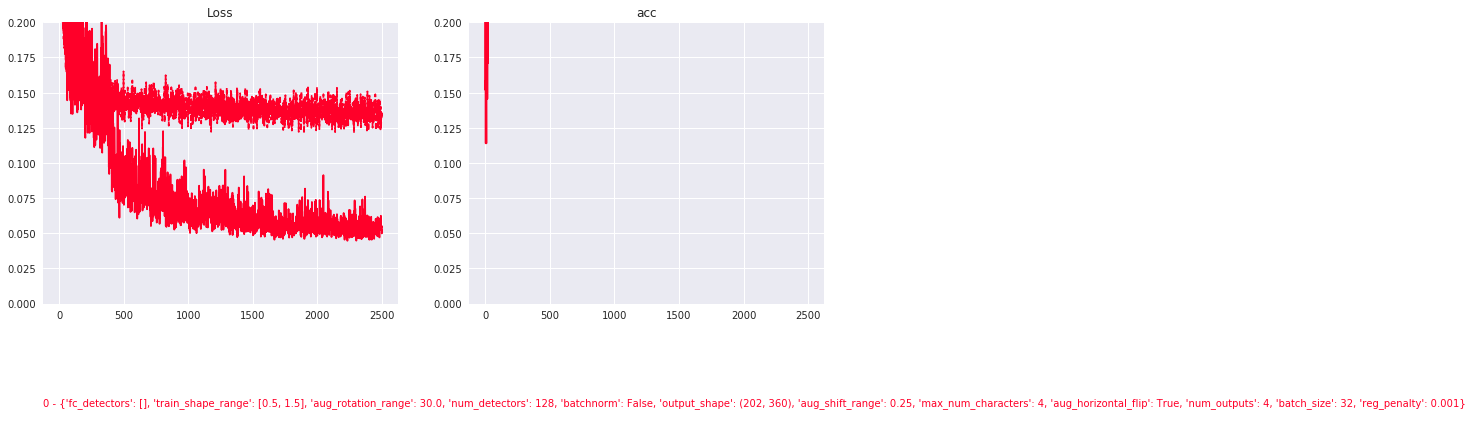

In [18]:
general.plotting.KerasHistoryPlotter().plot(gch.results, ylim=(0.,0.2))

In [19]:
simpsons.scoring.SimpsonsReporter(
        train_dev_X, train_dev_y, dev_X, dev_y, 
        dev_preprocess=simpsons_preprocess, generator_fn=frame_generator.generate,
        train_dev_num_images=500
).report(gch.results)

In [20]:
id = 0

model = gch.results[id].history.model
params = gch.results[id].params


## saving gch

In [22]:
import pickle
import gzip

# with gzip.GzipFile("/data/simpsons/gch.pickle.gz", "rb") as f:
#     gch = pickle.load(f)
    
with gzip.GzipFile("/data/simpsons/gch.pickle.gz", "wb") as f:
    pickle.dump(gch, f)

print("saving model for ", params)
model.save("/data/simpsons/model.hdf5")

saving model for  {'fc_detectors': [], 'train_shape_range': [0.5, 1.5], 'aug_rotation_range': 30.0, 'num_detectors': 128, 'batchnorm': False, 'output_shape': (202, 360), 'aug_shift_range': 0.25, 'max_num_characters': 4, 'aug_horizontal_flip': True, 'num_outputs': 4, 'batch_size': 32, 'reg_penalty': 0.001}


# Load a pre-trained model

In [13]:
model = keras.models.load_model("/data/simpsons/model.hdf5")

# Optimize classifier's thresholds 

In [23]:
dev_X = data.dev.X
dev_y = data.dev.y
dev_preds = model.predict(simpsons_preprocess.transform(dev_X))

In [24]:
cls = general.utils.ClassifierThresholdOptimizer(model, None, dev_y, preds=dev_preds)

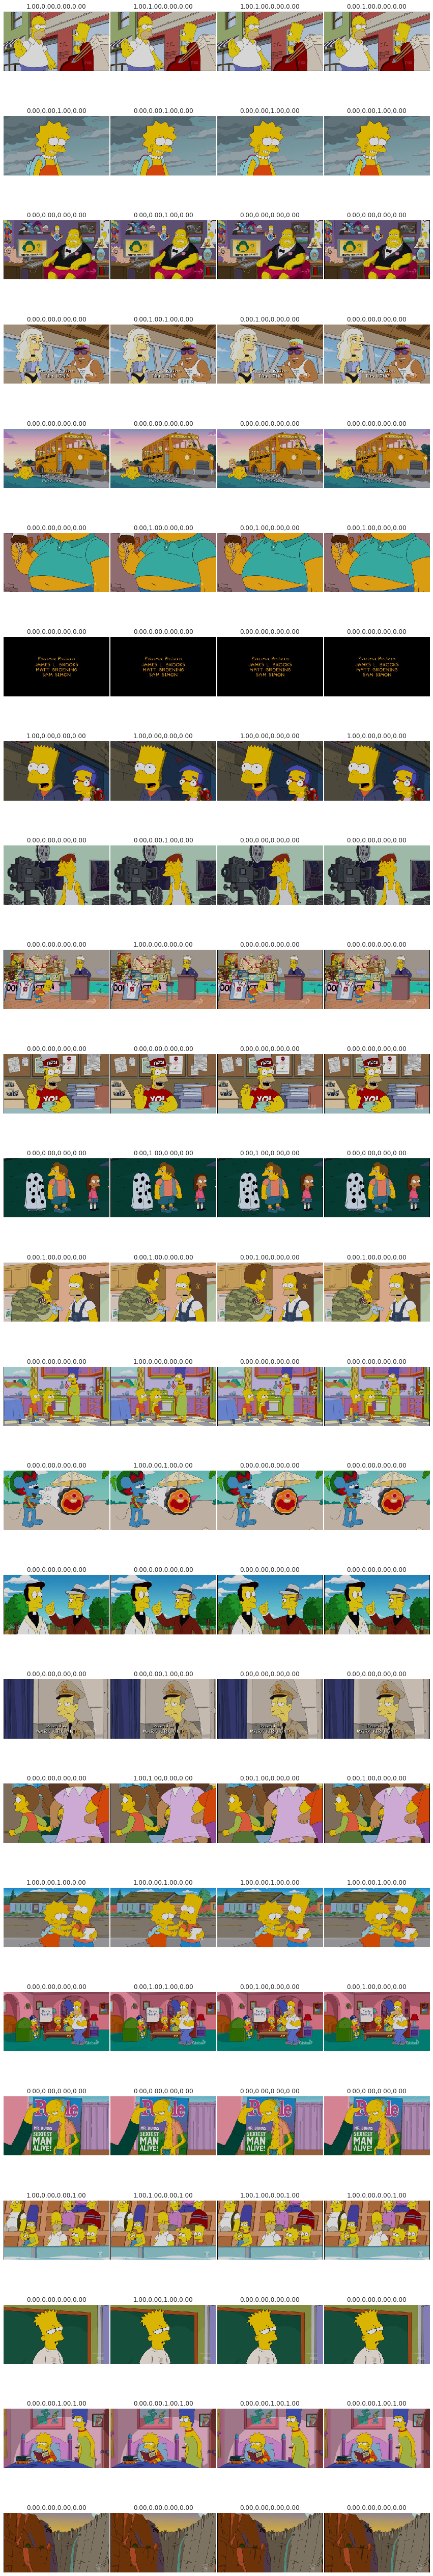

In [25]:
cls.fit(maximize_fscore=True)
preds_fscore = cls.predict(None, preds=dev_preds)

cls.fit(maximize_accuracy=True)
preds_acc = cls.predict(None, preds=dev_preds)

cls.fit(recall=0.75)
preds_rec_075 = cls.predict(None, preds=dev_preds)

cls.fit(precision=0.75)
preds_pre_075 = cls.predict(None, preds=dev_preds)

num_imgs = 25
general.plotting.gridplot_sidebyside(
    [dev_X[:num_imgs], preds_pre_075[:num_imgs]], 
    [dev_X[:num_imgs], preds_rec_075[:num_imgs]], 
    [dev_X[:num_imgs], preds_fscore[:num_imgs]], 
    [dev_X[:num_imgs], preds_acc[:num_imgs]]
)

In [26]:
# accuracy was chosen as the best one
cls.fit(maximize_accuracy=True)
cls.thresholds

array([ 0.3 ,  0.35,  0.3 ,  0.25])

# Performance on test set

In [27]:
test_preds = model.predict(simpsons_preprocess.transform(data.test.X))
test_preds = (test_preds > cls.thresholds).astype(int)
test_true = data.test.y

In [28]:
simpsons.scoring.final_report(test_true, test_preds)

Char #0 - bart
ACCURACY - 0.832
[[274   4]
 [ 55  18]]
             precision    recall  f1-score   support

        0.0       0.83      0.99      0.90       278
        1.0       0.82      0.25      0.38        73

avg / total       0.83      0.83      0.79       351




Char #1 - homer
ACCURACY - 0.758
[[213  36]
 [ 49  53]]
             precision    recall  f1-score   support

        0.0       0.81      0.86      0.83       249
        1.0       0.60      0.52      0.55       102

avg / total       0.75      0.76      0.75       351




Char #2 - lisa
ACCURACY - 0.877
[[285   2]
 [ 41  23]]
             precision    recall  f1-score   support

        0.0       0.87      0.99      0.93       287
        1.0       0.92      0.36      0.52        64

avg / total       0.88      0.88      0.85       351




Char #3 - marge
ACCURACY - 0.929
[[278   9]
 [ 16  48]]
             precision    recall  f1-score   support

        0.0       0.95      0.97      0.96       287
        1.0      

# Store final model and thresholds

In [29]:
model_and_thresholds = { "model": model, "preprocess_pipeline": simpsons_preprocess, "thresholds": cls.thresholds }
pickle.dump(model_and_thresholds, open("/data/simpsons/model_and_thresholds.pickle", "wb"))

# Show some generated training images

In [ ]:
from general.plotting import gridplot
frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
    background_images=background_images)

g = frame_generator.generate(data.train.X, data.train.y, max_num_characters=3, batch_size=32,
                             output_shape=config['training_img_shape'], train_shape_range=[0.3,1.0])
gen_imgs, gen_labels = next(g)
gridplot(gen_imgs, titles=gen_labels, num_cols=3)

# Train Log

## Trying to overfit on small samples and scale up
* 1 BG, 10 TRAIN, NO DIST, 25 epochs - overfitted perfectly.
* 1 BG, 50 TRAIN, NO DIST, 25 epochs - overfitted nicely. some positives get mid scores (0.4-0.6)
* 1 BG, ~500 TRAIN, NO DIST, 500 epochs - overfitted. get to loss = ~0.08 with a nice decrease over epochs. Validation stays flat.

__Apparently all above were run with a validation of pure data (not generated = no bg image).__  
__Apparently all above were run with vgg_means in scale of (0,255) and img in scale of (0,1).__

Fixing vgg_means and train_dev_generator:

* 1 BG, 50 TRAIN, NO DIST, 25 epochs - training loss drop to 0 pretty quickly. validation at ~0.05.

Trying with all training images.

* 1 BG, ~500 TRAIN, NO DIST, 25 epochs - train and val drops pretty much together to ~0.01-0.04 (loss). Results on dev are horrible. probably because of the single background image in train.
* ALL BG, ~500 TRAIN, NO DIST, 25 epochs - train and val to ~0.05. no overfitting. performs a bit better on dev but still sucks..

Adding more backgrounds (~100 now). Cleaning training images. Training images are now 100x200.  
Adding distortions back:

* ALL BG, ALL TRAIN, WITH DISTS, 40 epochs - no overfitting. train and train_dev together to ~0.05 (loss). validation looks nice. misses some (mostly when bart's hair is not in the image). might be because it was only trained for 40 epochs and didn't see a lot of distortions.

## Testing hyperparameters

1. what level to hook into? __clearly 5__
1. with/without first batchnorm (right after VGG)? __with__
1. dropout ratio (with first batchnorm) - __0.1, 0.25 and 0.5 are acceptable__
1. with/without second batchnorm (after detectors, before last FC) and dropout ratios - __without second batchnorm, 0 and 0.25 are fine__
1. trainall vs. traindelta? __clearly traindelta__


## Comparing performances on train_dev and dev

All settings are: ALL BG, ALL TRAIN, WITH DISTS, train_all=False, base_output_layer=5, batchnorm=True, dropout=0.25

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| default | loss ~0.05, no overfitting. AUC=0.94, 80%r=70%p | AUC=0.67, 80%r=10%p | maybe overfitting the train_dev. trying to increase dropout. |
| try with more zoom (0.9,2.5), 500 epochs, droprout=0.5 | noisy. loss ~0.08. AUC=0.65, 80%r=15%p | AUC=0.62, 80%r=5%p | looked at bart imgs in train_dev and dev and sorted by score. small barts get low score. large barts are identified easily. should try to train on 100x100 and move the patch on the frame |
| no shift_range, rotation=10.0, more zoom (1.0, 3.5), 500 epochs, dropout=0.5 | flat after epoch 200, loss ~0.13. AUC=0.82, 80%r=0%p|  AUC=0.65, 80%r=2%p| |

Changing training images back to 100x100. trying to get perfect fit on train_dev

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| train 100x100, zoom 1.0-1.5, no other dists, 50 epochs | loss ~0.08, AUC=0.87, 80%r=75%p | AUC=0.66 , 80%r=5%p | |

Changing training images - removing scaling to 100x100. every image is centered in black background of 100x100 but unscaled

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| train 100x100, zoom 1.0-1.5, no other dists, 50 epochs | AUC=0.95 , 80%r=70%p | AUC=0.61  , 80%r=0%p |  |

Train images are 100x100. Changing dev images to 202x360 (50% of orig).

| settings | train_dev performance | dev performance | comments |
| --- | --- | --- | --- |
| no dists, 100 epochs | AUC=1.00 , 80%r=100%p | AUC=0.69 , 80%r=40%p | By looking at dev, I believe the main problem is the black edge on training images  |
| changed train gen to reduce black edge. 50 epochs | AUC=0.74 , 80%r=30%p | AUC=0.82 , 80%r=40%p | |
| \*same\*.  training 50 epochs more. __Also calculating train_dev stats on many iterations__ | AUC=0.96 , 80%r=90%p | AUC=0.81 , 80%r=45%p | |
| \*same\*.  training 100 epochs more. | AUC=0.96 , 80%r=90%p | AUC=0.78 , 80%r=50%p | looks much better when examining dev. should try to add more dists and check if it's better to predict on the whole dev image or slide across it |
| adding dists: rotate 10.0, zoom: [0.9,1.5]. comparing dropout=0,25, 0.5. 100 epochs | | | | 
| \* _dropout=0.25_ | AUC=0.94, 80%r=80%p | full: AUC=0.77, 80%r=50%p. patches: AUC=0.8, 80%r=50%p | |
| \* _dropout=0.5_ | AUC=0.92, 80%r=70%p | full: AUC=0.77, 80%r=50%p. patches: AUC=0.81, 80%r=40%p | | 
| 100 epochs more (dropout=0.25) | AUC=0.92, 80%r=70%p | full: AUC=0.77, 80%r=35%p. patches: AUC=0.79, 80%r=55%p | | |
| 500 epochs more (dropout=0.25) | AUC=0.97, 80%r=80%p | full: AUC=0.75, 80%r=45%p. patches: AUC=0.78, 80%r=30%p | | |

## Adding marge

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| 200 epochs | 0.97, 0.94 | 80%, 75% | 0.73, 0.86 | 35%, 50% | should try with more detectors |
| tried with 32,64,128 detetors. lost the data. keep with 32 detectors ||||||
| > Focusing on making train closer to dev. Mainly by image manipulation. I believe a better training images generation and a better patch_img_on_background process will get significant results. <br/><br/> changing training image rescaling method to __'lanczos'__ (looks better with the characters edges). Also removed all dists. 100 epochs | 0.98, 0.96 | 85%, 95% | 0.67, 0.84 | 30%, 40% | |
| changed black sensitivity in patch_img_on_background (0.3 -> 0.1). 100 epochs | 0.95, 0.9 | 85%, 80%| 0.67, 0.86 | 20%, 40% | | 
| adding dists back: (100 epochs) | | | | | |
| + zoom [0.9, 1.2] | 0.96, 0.98 | 85%, 90% | 0.64, 0.82 | 85%, 40% | * 85%?? reading error? |
| + rotation 10.0 | 0.98, 0.98 | 80%, 85% | 0.64, 0.74 | 25%, 20% | should remove rotation. it makes images grainy on the edges. Also - scale 0.8 looks a bit better |
| removing rotation. zoom only [0.9, 1.5] | 0.94, 0.92 | 80%, 80% | 0.66, 0.78 | 15%, 35% | scaled dev (0.7) brings results to 0.70, 0.81, 15%, 50% |
| training 100 epochs more (200 total) | 0.97, 0.94 | 85%, 65% | 0.69, 0.83 | 20%, 50% | |
| no dists, 200 epochs | 0.99, 1.00 | 95%, 95% | 0.67, 0.74 | 20%, 30% | scaled (0.7) brings marge to 0.84 and 50%. In general, scale 0.7 seems optimal for AUC in both characters | 

Increasing training size to (150,150). Still bart and marge only

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| no dists, 100 epochs | 0.99, 0.97 | 95%, 90% | 0.69, 0.90 | 30%, 70%| |
| with zoom [1.0, 1.5], 100 epochs | 0.98, 0.96 | 90%, 80% | 0.69, 0.87 | 30%, 55% | |
| no dists. 200 epochs | 0.97, 0.96 | 90%, 90% | 0.70, 0.85 | 35%, 65% | |
| AUC/epoch analysis shows that there is no increasing of AUC after 100 epochs. | | | | | should try on all characters |
| Added blur to patch_img_on_background. no dists. 100 epochs | 1.00, 1.00 | 100%, 95% | 0.74, 0.86 | 40%, 60% | |


Keeping the blur on training images.  

## All characters

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| no dists, 100 epochs. 16 detectors | ~1.00 | ~90% | 0.65,0.86,0.66,0.38,0.76 | 35%,55%,5%,0%,20%| |
| no dists, 100 epochs. 32 detectors | ~1.00 | ~90%-95% | 0.68,0.79,0.64,0.38,0.82 | 30%,20%,5%,0%,50% | |
| no dists, 100 epochs. 48 detectors | ~0.98 | ~90%-100% | 0.65,0.82,0.65,0.54,0.86 | 20%,20%,15%,0%,50%| |
| no dists, 100 epochs. 64 detectors | ~1.00 | ~90%-100% | 0.65,0.85,0.64,0.46,0.85 | 15%,40%,10%,0%,60%| |

Observations: 
* detectors num - keep it 48 for now. not much of a difference
* number of epochs - helps only marge.
* severe problem with maggie. 
* maggie gets better results on zoom > 1.5 (others - not significant impact)
* a lot of misses on small characters (weird with the previous bullet)
* maybe should measure "maximal acceptance precision" as a lot of the images that contain a character, contains it poorly.

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| adding zoom [1.0, 2.0], 100 epochs (48 detectors) | ~0.95 | ~70%-90% | 0.72,0.74,0.63,0.42,0.78 | 15%,5%,5%,0%,35% | |
| no dists. fc_detectors=[64]. 100 epochs | ~1.00 | ~90% | 0.66,0.79,0.66,0.54,0.84 | 30%,30%,10%,0%,50% | |
| no dists. fc_detectors=[64,64]. 50 epochs | ~1.00 | ~90%-100% | 0.63,0.8,0.59,0.35,0.85 | 20%,10%,20%,0%,55% | |


## Zero-score dev pics analysis

| Character | # pics in dev | # should find | % should find | % > 0.5 | # super hard | % super hard | comments | 
| --- |
| Bart | 38 | 25 | 65% | 34% | 11 | 29% | Some super-hards with baseball cap on. In some, Bart is very small (50x70). In some - turning his back |
| Homer | 48 | 41 | 85% | 40% | 4 | 8% | Missing some where Homer is small (opening frames) but in some he is very large in the frame |
| Lisa | 40 | 20 | 50% | 15% | 8 | 20% | A lot of small Lisa's |
| Maggie | 14 | 8 | 57% | 0% | 3 | 21% | All get 0.0. Single one gets 0.08. Maggie is very small in almost all pics (~70x70). |
| Marge | 48 | 38 |80% | 33% | 10 | 20% | Turning her back. few too large, few too little |

Conclusions: 
* Should work on "multi-size" model.
* Check why adding parts to an image (taking larger areas) reduces (sometimes dramatically) the score
  * Try to remove BatchNorm. It changes detectors outputs when overall image is changing..

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| trying without batchnorm. 100 epochs | ~0.98 | ~90%-100%| 0.71,0.84,0.62,0.56,0.83| 20%,15%,20%,10%,40%| |  
| trying a "small model" vs a "large model" | | | | | |
| * small model - all training imgs with zoom=2.0 | 0.89,0.87,0.86,0.85,0.96 | 15%-70% | 0.70,0.73,0.59,0.48,0.74 | 10%-40% | |
| * large model - all training imgs with zoom=1.0 | 0.99,0.99,0.98,1.00,0.97 | 50%-100% | 0.67,0.83,0.60,0.62,0.87 | 10%-50% | | 

Changing the train generator:   
* Using rescale to create smaller images
* Cropping empty borders so character fills the entire image in all sizes

Adding a "combined PR curve" that measures recall when setting both large and small models on the same precision.

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| No dists. small=(100,100) | 1.00,0.99,1.00,1.00,1.00 | 95%-100% | 0.60,0.81,0.61,0.59,0.77 | 10%-50% | |
| No dists. large=(150,150) | 1.00,1.00,1.00,1.00,0.97 | 90%-100% | 0.61,0.87,0.63,0.63,0.84 | 10%-65% | |
| Combined | | | | 15%-65% | |
| | | | | | |
| *Changing dropout to 0.2*, Adding dists: 5.0 rotation, 0.05 shift, 0.1 zoom. Trying various sizes of training images | | | | | | 
| tiny (50,50) | 0.95,0.92,0.93,0.97,0.90 | 50%-70% |      0.63,0.48,0.56,0.59,0.61 | 10%-35% | |
| v.small (75,75) | 1.00,0.99,0.99,1.00,0.99 | 85%-100% |  0.63,0.80,0.63,0.61,0.60 | 10%-50% | |
| small (100,100) | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.59,0.76,0.64,0.59,0.75 | 10%-45% | |
| large (150,150) | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.62,0.89,0.66,0.57,0.82 | 10%-75% | |
| v.large (200,200) | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.61,0.92,0.64,0.56,0.78 | 10%-75% | |


### New test set - 700 frames from 100 episodes.

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| small (100,100) | 0.98,0.96,0.99,1.00,0.98 | 60%-100% | 0.66,0.65,0.67,0.44,0.75 | 5%-35% | |
| large | 1.00,0.99,1.00,1.00,1.00 | 100%-100% | 0.68,0.78,0.72,0.47,0.83 | 5%-45% | |
| trying different # dets | 
| 32 dets | 0.99,0.98,0.99,0.97,0.94 | 60%-100% |  0.71,0.79,0.67,0.43,0.83 | 5%-45% | | 
| 64 dets | 0.99,0.99,0.99,0.99,0.96 | 65%-100% |  0.72,0.81,0.68,0.41,0.83 | 5%-50% | |
| 128 dets | 0.99,0.99,0.99,0.98,0.99 | 70%-100% | 0.71,0.81,0.69,0.41,0.84 | 5%-55% | |
| 256 dets | 0.54,1.00,0.99,1.00,0.96 | 20%-100% | 0.45,0.77,0.72,0.42,0.81 | 5%-45% | weird.. got stuck on characters multiple times |
| 512 dets | 0.99,1.00,0.99,0.75,0.96 | 15%-100% | 0.72,0.78,0.71,0.43,0.83 | 5%-45% | |
| 1024 dets | 0.99,1.00,0.99,0.75,0.59 | 5%-100% | 0.69,0.79,0.71,0.47,0.36 | 5%-45% | |
| 2048 dets | 1.00,1.00,0.98,0.78,0.45 | 5%-100% | 0.73,0.81,0.68,0.43,0.33 | 5%-50% | |
| 128 dets, different dropouts | 
| 128 dets, dropout=0.5 | 1.00,1.00,0.99,1.00,1.00 | 100%-100% | 0.72,0.78,0.75,0.43,0.79 | 5%-45% | |
| 128 dets, dropout=0.2 | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.75,0.80,0.72,0.40,0.79 | 5%-50% | |
| 128 dets, dropout=0.2, different num_epochs | 
| 10 epochs | 0.55,0.93,0.95,0.94,0.74 | 10%-75% |    0.43,0.79,0.62,0.42,0.54 | 5%-45% | |
| 20 epochs | 0.51,0.98,0.98,0.96,0.95 | 20%-100% |   0.43,0.80,0.67,0.37,0.73 | 5%-45% | |
| 30 epochs | 0.88,0.98,0.99,0.98,0.95 | 25%-100% |   0.64,0.80,0.66,0.37,0.82 | 5%-50% | |
| 40 epochs | 0.99,0.99,0.99,1.00,0.96 | 70%-100% |   0.74,0.78,0.70,0.41,0.81 | 5%-45% | |
| 50 epochs | 0.99,0.99,1.00,1.00,0.96 | 85%-100% |   0.74,0.79,0.66,0.38,0.81 | 5%-45% | |
| 50 epochs | 1.00,1.00,0.99,0.99,0.98 | 80%-100% |   0.74,0.77,0.69,0.41,0.83 | 5%-45% | |
| 60 epochs | 0.99,1.00,0.99,1.00,1.00 | 95%-100% |   0.74,0.79,0.67,0.40,0.81 | 5%-45% | |
| 100 epochs | 1.00,1.00,0.99,1.00,0.99 | 100%-100% | 0.73,0.75,0.71,0.47,0.82 | 5%-45% | |
| 150 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.78,0.73,0.44,0.80 | 5%-45% | |
| 200 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.72,0.78,0.72,0.44,0.80 | 5%-45% | |
| 250 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.79,0.75,0.41,0.82 | 5%-45% | |
| 300 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.70,0.77,0.75,0.40,0.80 | 5%-45% | |
| 350 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.79,0.75,0.40,0.81 | 5%-45% | |
| 400 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.71,0.79,0.74,0.40,0.80 | 5%-45% | |
| 450 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.70,0.77,0.74,0.39,0.81 | 5%-40% | |
| 500 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.72,0.78,0.76,0.39,0.83 | 5%-45% | |
| 550 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.74,0.78,0.74,0.38,0.80 | 5%-40% | |
| 600 epochs | 1.00,1.00,1.00,1.00,1.00 | 100%-100% | 0.74,0.78,0.75,0.37,0.80 | 5%-45% | |

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| small (75,75), 60 epochs |   0.98,0.98,0.98,0.98,0.90 | 25%-95% |  0.71,0.65,0.61,0.36,0.64 | 5%-40% | |
| large (200,200), 60 epochs | 1.00,1.00,0.98,0.97,0.97 | 55%-100% | 0.73,0.80,0.70,0.44,0.82 | 5%-50% | |
| combined | 

Regenerating training images to be (200,200). completely ignoring images that are less than (200,200) (in both dimentions).  
** Also: removing maggie **  
** adding stratified splitting of train/test sets**

| settings | train_dev performance || dev performance || comments |
| --- | --- | --- | --- | --- | --- |
| | __AUC__ | __% prec for 80% recall__ | __AUC__ | __% prec for 80% recall__ | |
| small (75,75), 200 epochs |   1.00,0.97,1.00,0.99 | 90%-100% |  0.73,0.67,0.63,0.71 | 25%-35% | |
| large (200,200), 200 epochs | 1.00,1.00,1.00,1.00 | 100%-100% | 0.76,0.72,0.72,0.81 | 30%-40% | |
| combined | | | | 30.0,40.0,25.0,35.0 |
| |
| Adding zoom 0.5-1.5 to both large and small |
| small (75,75), 100 epochs | 0.93,0.92,0.96,0.96 | 55%-85% | 0.71,0.57,0.59,0.68 | 20%-30% |
| large (200,200), 100 epochs | 0.99,0.99,0.99,0.99 | 70%-100% | 0.76,0.76,0.69,0.83 | 25%-45% |
| combined, 100 epochs | | | | 30.0,40.0,20.0,35.0 |
| small (75,75), 250 epochs | 0.98,0.94,0.95,0.99 | 70%-90% | 0.72,0.63,0.64,0.73 | 25%-35% | |
| large (200,200), 250 epochs | 1.00,0.99,1.00,1.00 | 95%-100% | 0.74,0.76,0.69,0.79 | 25%-45% | |
| combined, 250 epochs | | | | 30.0,45.0,25.0,35.0 |
| |
| Training image is now at size of background with the character placed randomaly inside. Adding zoom [1.0,2.0], trying a single model | |
| 100 epochs | 0.98,0.99,0.99,1.00 | 95%-100% |  0.82,0.75,0.71,0.82 | 25%-45% | |
| 200 epochs | 1.00,0.98,1.00,1.00 | 95%-100% |  0.80,0.75,0.72,0.82 | 25%-40% | |
| 300 epochs | 1.00,0.98,0.99,1.00 | 95%-100% |  0.81,0.73,0.72,0.82 | 25%-40% | |
| 400 epochs | 1.00,1.00,1.00,1.00 | 100%-100% | 0.78,0.75,0.73,0.82 | 25%-40% | |
| | 
| Trying large and small, 100 epochs |
| small - output_shape=(100,100) | 0.92,0.89,0.95,0.97 | 50%-80% |   0.72,0.63,0.67,0.77 | 25%-35% |
| large - output_shape=None (bg) | 1.00,1.00,1.00,0.93 | 100%-100% | 0.72,0.72,0.71,0.73 | 25%-40% |
| combined | | | | 35.0,40.0,25.0,30.0 |
| |
| Changing zoom mechanism to change the size of the whole training image, thus making it "moving" on the background. |
| single model - output_shape=None, train_shape_range=[0.3,1.0], 200 epochs | 0.99,0.99,1.00,0.99 | 95%-100% | 0.78,0.75,0.73,0.82 | 25%-40% | |
| small - output_shape=(100,100), train_shape_range=[0.6,1.0], 200 epochs | 0.98,0.97,0.96,0.99 | 75%-90% | 0.71,0.64,0.70,0.61 | 25%-35% |  |
| large - output_shape=None, train_shape_range=[0.6,1.0], 200 epochs | 1.00,1.00,1.00,1.00 | 100%-100% | 0.73,0.70,0.72,0.79 | 25%-35% | |
| small+large | | | | 35.0,35.0,25.0,30.0 |


# Measure "acceptable" recall rates per character

In [46]:
num_images_per_char = 50
dev_with_chars = [ 
    np.random.permutation(np.argwhere(data.dev.y[:,char_id] == 1).flatten())[:num_images_per_char]
    for char_id in range(data.dev.y.shape[1])
]

In [47]:
num_acceptable_misses = np.array([ 9, 7, 4, 7])
EXPECTED_RECALL = (1 - num_acceptable_misses / num_images_per_char)
EXPECTED_RECALL


array([ 0.82,  0.86,  0.92,  0.86])

In [ ]:
gridplot(data.dev.X[dev_with_chars[3]], num_cols=4)